<a href="https://colab.research.google.com/github/nikhil-xb/Tomato-Plant-Disease-Identification/blob/main/Tomato_Leaves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 549 kB 5.0 MB/s 
     |████████████████████████████████| 182 kB 74.6 MB/s 


In [ ]:
import os
import copy
import random
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tqdm as tq
from tqdm.notebook import tqdm
import timm
import time

import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torchvision import transforms, datasets, models, utils
from torch.utils.data import Dataset, DataLoader
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings('ignore')

In [ ]:
train_path= '/content/drive/MyDrive/DataSets/Tomato/train'

In [ ]:
def plot_results(train_acc, valid_acc, train_loss, valid_loss, nb_epochs):
    epochs = [i for i in range(nb_epochs)]
    
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(20, 10)
    
    ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
    ax[0].plot(epochs, valid_acc, 'ro-', label='Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    
    ax[1].plot(epochs, train_loss, 'go-', label='Training Loss')
    ax[1].plot(epochs, valid_loss, 'ro-', label='Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    
    plt.show()

In [ ]:

# def KM(main_):
#     rgb_img= cv2.cvtColor(main_, cv2.COLOR_BGR2RGB)
#     vectorized= rgb_img.reshape((-1,3))
#     vectorized= np.float32(vectorized)
#     criteria= (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER,100,.85)
#     K=3
#     attempts= 10
#     ret, label, center= cv2.kmeans(vectorized, K,None, criteria, attempts, cv2.KMEANS_RANDOM_CENTERS)
#     center= np.uint8(center)
#     seg_data= center[label.flatten()] #type: ignore
#     seg_img= seg_data.reshape((main_.shape)) 
#     contoured_img= cv2.Canny(seg_img, 150,200)
#     return seg_img
#     # return contoured_img

In [ ]:
class Config:
  CFG= {
            'img_size': 224,
            'wd': 1e-6
        }
class Augments:
   train= transforms.Compose([
       transforms.Resize((Config.CFG['img_size'], Config.CFG['img_size'])),
       transforms.RandomHorizontalFlip(p=0.3),
       transforms.RandomVerticalFlip(p=0.3),
       transforms.RandomResizedCrop(Config.CFG['img_size']),
       transforms.ToTensor(),
       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
   ])
   valid= transforms.Compose([
          transforms.Resize((Config.CFG['img_size'], Config.CFG['img_size'])),
          transforms.ToTensor(),
          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
   ])

In [ ]:
class_names= os.listdir(train_path)

In [ ]:
class Tomato(torch.utils.data.Dataset):
  def __init__(self, data_dir, class_names,img_size= Config.CFG['img_size'],transform=None):
    super().__init__()
    self.class_names= class_names
    self.img_size= img_size
    self.transform= transform
    self.X=[]
    self.Y=[]
    i=0
    for class_ in class_names:
      class_dir= os.path.join(data_dir, class_)
      images= os.listdir(class_dir)
      for image in tq.tqdm(images):
        image_path= os.path.join(class_dir,image)
        img= Image.open(image_path).convert("RGB")
        self.X.append(img)
        self.Y.append(int(class_names.index(class_)))
  def __getitem__(self,index):
    if torch.is_tensor(index):
      index= index.tolist()
    sample= {'image': self.X[index],
             'label': self.Y[index]
             }
    if self.transform is not None:
      sample['image']= self.transform(sample['image'])
    return sample
  def __len__(self):
    return len(self.X)
  def getXY(self):
    return self.X, self.Y

In [ ]:
tomato_data= Tomato(data_dir= train_path, class_names=class_names)

100%|██████████| 764/764 [00:10<00:00, 74.92it/s] 


0 (256, 256) Bacterial_spot


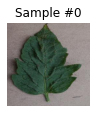

1 (256, 256) Bacterial_spot


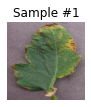

2 (256, 256) Bacterial_spot


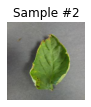

3 (256, 256) Bacterial_spot


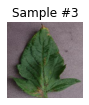

In [ ]:
fig= plt.figure()
for i in range(len(tomato_data)):
  sample= tomato_data[i]
  print(i, sample['image'].size, class_names[int(sample['label'])])
  ax= plt.subplot(1,4,i+1)
  plt.tight_layout()
  ax.set_title("Sample #{}".format(i))
  ax.axis('off')
  plt.imshow(sample['image'])
  plt.show()
  if i==3:
    plt.show()
    break

In [ ]:
from sklearn.model_selection import train_test_split
X,y= tomato_data.getXY()
indices= [t for t in range(len(tomato_data))]
X_train, X_test, Y_train, Y_test, train_idx, valid_idx= train_test_split(X,y, indices, test_size= 0.05, stratify=y, shuffle=True)


In [ ]:
train_dataset= torch.utils.data.Subset(tomato_data,train_idx)
valid_dataset= torch.utils.data.Subset(tomato_data,valid_idx)

In [ ]:
class MapDataset(torch.utils.data.Dataset):
  def __init__(self,dataset,map_fn=None):
    self.dataset= dataset
    self.map= map_fn
  def __getitem__(self,index):
    x= self.dataset[index]['image']
    if self.map:
      x= self.map(x)
    y= self.dataset[index]['label']
    return x, y
  def __len__(self):
    return len(self.dataset)

Possible Problem:
* The image upon "Canny" edge detection got the shape of (256x256) hence 2d instead of 3 channels
* The batches num given are taking wrong values as batches
* The error got: 
> groups=1, weight of size [64, 3, 7, 7], expected input[16, 256, 256, 3] to have 3 channels, but got 256 channels instead

In [ ]:
Batch_Size= 16
tng_tf= MapDataset(train_dataset, Augments.train)
valid_tf= MapDataset(valid_dataset, Augments.valid)

tng_load= torch.utils.data.DataLoader(tng_tf,batch_size=Batch_Size, num_workers=4,shuffle= True)


valid_load= torch.utils.data.DataLoader(valid_tf,batch_size=Batch_Size, num_workers=4,shuffle=True)


In [ ]:
### Model Classes

class ResNextModel(nn.Module):
  def __init__(self,num_classes= 11, model_name= 'resnext101_32x8d',pretrained= True):
    super(ResNextModel,self).__init__()
    self.model= timm.create_model(model_name, pretrained=
                                  pretrained)
    self.model.fc= nn.Linear(self.model.fc.in_features, num_classes)
  def forward(self,x):
    x= self.model(x)
    return x

class ResNetModel(nn.Module):
  def __init__(self,num_classes= 11, model_name= 'resnet18',pretrained= True):
    super(ResNetModel,self).__init__()
    self.model= timm.create_model(model_name, pretrained=
                                  pretrained)
    self.model.fc= nn.Linear(self.model.fc.in_features, num_classes)
  def forward(self,x):
    x= self.model(x)
    return x
class EfficientNetModel(nn.Module):
  def __init__(self,num_classes= 11, model_name= 'efficientnet_b5',pretrained= True):
    super(EfficientNetModel,self).__init__()
    self.model= timm.create_model(model_name, pretrained=
                                  pretrained)
    self.model.classifier= nn.Linear(self.model.classifier.in_features, num_classes)
  def forward(self,x):
    x= self.model(x)
    return x 

class VITModel(nn.Module):
  def __init__(self,num_classes= 11, model_name= 'vit_base_patch16_224',pretrained= True):
    super(VITModel,self).__init__()
    self.model= timm.create_model(model_name, pretrained=
                                  pretrained)
    self.model.head= nn.Linear(self.model.head.in_features, num_classes)
  def forward(self,x):
    x= self.model(x)
    return x 

'''class My_Model(nn.Module):
  def __init__(self, infeatures, num_classes=11):
    super(My_Model, self).__init__()
    self.fc1= nn.Linear(infeatures,1024)
    self.fc2= nn.Linear(1024,num_classes)
  def forward(self,x):
    x= self.fc1(x)
    x= nn.Dropout(0.15)(x)
    x= F.relu(x)
    x= self.fc2(x)
    return x
last_ftrs= model_ft.fc.in_features
my_model= My_Model(last_ftrs,len(class_names))  '''

'class My_Model(nn.Module):\n  def __init__(self, infeatures, num_classes=11):\n    super(My_Model, self).__init__()\n    self.fc1= nn.Linear(infeatures,1024)\n    self.fc2= nn.Linear(1024,num_classes)\n  def forward(self,x):\n    x= self.fc1(x)\n    x= nn.Dropout(0.15)(x)\n    x= F.relu(x)\n    x= self.fc2(x)\n    return x\nlast_ftrs= model_ft.fc.in_features\nmy_model= My_Model(last_ftrs,len(class_names))  '

In [ ]:
dataloader= {
    'train': tng_load,
    'val': valid_load
}
dataset_size= {
    'train': len(train_dataset),
    'val': len(valid_dataset)
}

In [ ]:
nb_epochs= 10
device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
!nvidia-smi

Sat Dec  3 17:30:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W /  70W |      3MiB / 15109MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title Default title text
class Trainer:
  def __init__(self,model,optimizer, loss_fn, val_loss_fn, scheduler, device="cuda:0", plot_results=True):
    self.optimizer= optimizer
    self.loss_fn= loss_fn
    self.val_loss_fn= val_loss_fn
    self.scheduler= scheduler
    self.device= device
    
    self.plot_results= plot_results
  def train_one_cycle(self):
    model.train()
    train_prog_bar= tqdm(dataloader['train'], total= len(dataloader['train']))
    
    all_train_labels, all_train_preds= [], []
    running_loss= 0

    for xtrain, ytrain in train_prog_bar:
      xtrain= xtrain.to(device).float()
      ytrain= ytrain.to(device).long()
      with autocast():
        # Get predictions
        z = model(xtrain)

        # Training
        train_loss = self.loss_fn(z, ytrain)
        scaler.scale(train_loss).backward()
        
        scaler.step(self.optimizer)
        scaler.update()
        self.optimizer.zero_grad()
        running_loss += train_loss

        # Convert the predictions and corresponding labels to right form
        train_predictions = torch.argmax(z, 1).detach().cpu().numpy()
        train_labels = ytrain.detach().cpu().numpy()

        # Append current predictions and current labels to a list
        all_train_labels += [train_predictions]
        all_train_preds += [train_labels]

      # Show the current loss to the progress bar
      train_pbar_desc = f'loss: {train_loss.item():.4f}'
      train_prog_bar.set_description(desc=train_pbar_desc)
        
    # After all the batches are done, calculate the training accuracy
    all_train_preds = np.concatenate(all_train_preds)
    all_train_labels = np.concatenate(all_train_labels)
    
    train_acc = (all_train_preds == all_train_labels).mean()
    print(f"Training Accuracy: {train_acc:.4f}")
    
    # Now average the running loss over all batches and return
    train_running_loss = running_loss / len(dataloader['train'])
    
    # Free up memory
    del all_train_labels, all_train_preds, train_predictions, train_labels,xtrain,ytrain, z
    
    return (train_acc, train_running_loss)

  def valid_one_cycle(self):
      """
      Runs one epoch of prediction and validation accuracy calculation
      """        
      model.eval()
      valid_prog_bar = tqdm(dataloader['val'], total=len(dataloader['val']))
      
      with torch.no_grad():
          all_valid_labels = []
          all_valid_preds = []
          
          running_loss = 0
          
          for xval, yval in valid_prog_bar:
              xval = xval.to(device).float()
              yval = yval.to(device).long()
              
              val_z = model(xval)
              
              val_loss = self.val_loss_fn(val_z, yval)
              
              running_loss += val_loss.item()
              
              val_pred = torch.argmax(val_z, 1).detach().cpu().numpy()
              val_label = yval.detach().cpu().numpy()
              all_valid_labels += [val_label]
              all_valid_preds += [val_pred]
          
              # Show the current loss
              valid_pbar_desc = f"loss: {val_loss.item():.4f}"
              valid_prog_bar.set_description(desc=valid_pbar_desc)
          
          # Get the final loss
          final_loss_val = running_loss / len(dataloader['val'])
          
          # Get Validation Accuracy
          all_valid_labels = np.concatenate(all_valid_labels)
          all_valid_preds = np.concatenate(all_valid_preds)
          
          val_accuracy = (all_valid_preds == all_valid_labels).mean()
          print(f"Validation Accuracy: {val_accuracy:.4f}")
          
          # Free up memory
          del all_valid_labels, all_valid_preds, val_label, val_pred, xval, yval, val_z
          
      return (val_accuracy, final_loss_val, model)



        


In [ ]:
model= VITModel().to(device)

In [ ]:
fold=1

In [ ]:
## Path for saving the model paramter for epoch_x and fold_y
model_version= F"Fold{fold}.pt"
path= F"/content/drive/MyDrive/DataSets/Tomato/{model_version}" 

In [ ]:
## For Loading the model 
model_version= F'Fold{fold}.pt'
path= F'/content/drive/MyDrive/DataSets/Tomato/{model_version}'
model.load_state_dict(torch.load(path,map_location=torch.device('cpu'))) 

<All keys matched successfully>

-------------------- EPOCH: 0/10 --------------------


  0%|          | 0/386 [00:00<?, ?it/s]

Training Accuracy: 0.9727


  0%|          | 0/21 [00:00<?, ?it/s]

Validation Accuracy: 0.9938
Saving Model for this epoch...
-------------------- EPOCH: 1/10 --------------------


  0%|          | 0/386 [00:00<?, ?it/s]

Training Accuracy: 0.9671


  0%|          | 0/21 [00:00<?, ?it/s]

Validation Accuracy: 0.9877
Saving Model for this epoch...
-------------------- EPOCH: 2/10 --------------------


  0%|          | 0/386 [00:00<?, ?it/s]

Training Accuracy: 0.9724


  0%|          | 0/21 [00:00<?, ?it/s]

Validation Accuracy: 0.9877
Saving Model for this epoch...
-------------------- EPOCH: 3/10 --------------------


  0%|          | 0/386 [00:00<?, ?it/s]

Training Accuracy: 0.9745


  0%|          | 0/21 [00:00<?, ?it/s]

Validation Accuracy: 0.9754
Saving Model for this epoch...
-------------------- EPOCH: 4/10 --------------------


  0%|          | 0/386 [00:00<?, ?it/s]

Training Accuracy: 0.9745


  0%|          | 0/21 [00:00<?, ?it/s]

Validation Accuracy: 0.9908
Saving Model for this epoch...
-------------------- EPOCH: 5/10 --------------------


  0%|          | 0/386 [00:00<?, ?it/s]

Training Accuracy: 0.9794


  0%|          | 0/21 [00:00<?, ?it/s]

Validation Accuracy: 0.9785
Saving Model for this epoch...
-------------------- EPOCH: 6/10 --------------------


  0%|          | 0/386 [00:00<?, ?it/s]

Training Accuracy: 0.9765


  0%|          | 0/21 [00:00<?, ?it/s]

Validation Accuracy: 0.9908
Saving Model for this epoch...
-------------------- EPOCH: 7/10 --------------------


  0%|          | 0/386 [00:00<?, ?it/s]

Training Accuracy: 0.9762


  0%|          | 0/21 [00:00<?, ?it/s]

Validation Accuracy: 0.9877
Saving Model for this epoch...
-------------------- EPOCH: 8/10 --------------------


  0%|          | 0/386 [00:00<?, ?it/s]

Training Accuracy: 0.9778


  0%|          | 0/21 [00:00<?, ?it/s]

Validation Accuracy: 0.9846
Saving Model for this epoch...
-------------------- EPOCH: 9/10 --------------------


  0%|          | 0/386 [00:00<?, ?it/s]

Training Accuracy: 0.9802


  0%|          | 0/21 [00:00<?, ?it/s]

Validation Accuracy: 0.9785
Saving Model for this epoch...


TypeError: ignored

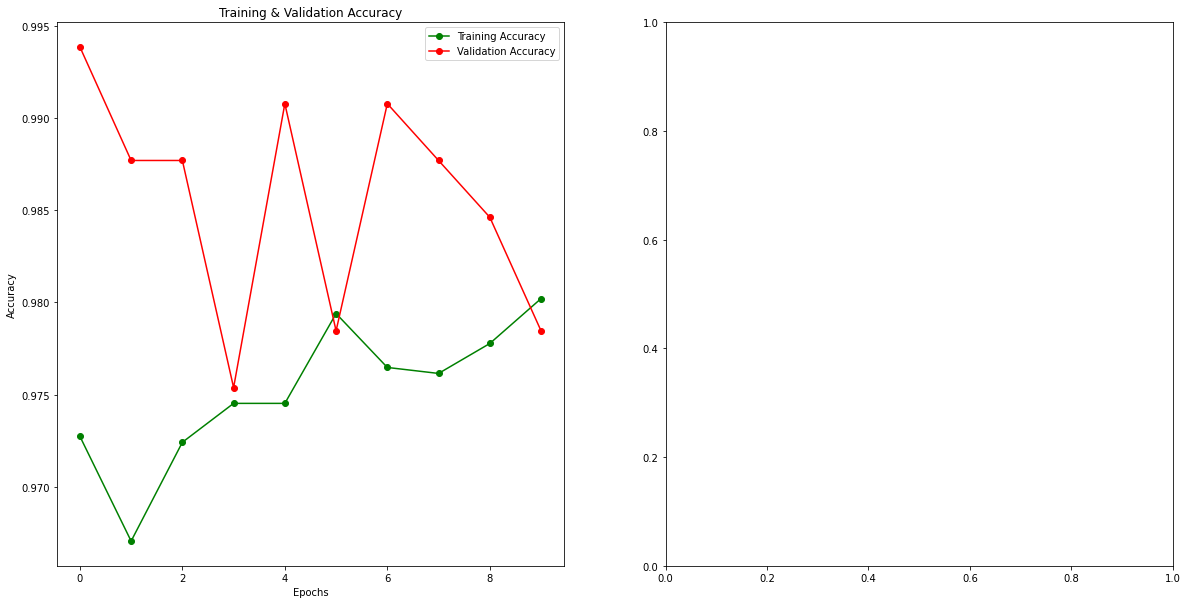

In [ ]:


#@title Default title text

fold=2

optim= torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay= Config.CFG['wd']) #decrease learning rate
loss_fn= nn.CrossEntropyLoss().to(device)
loss_fn_val= nn.CrossEntropyLoss().to(device) 

trainer= Trainer(model=model, optimizer=optim, loss_fn=loss_fn, val_loss_fn= loss_fn_val, scheduler=None, device=device)
train_accs = []
valid_accs = []
train_losses = []
valid_losses = []

scaler = GradScaler()

for epoch in range(nb_epochs):
    print(f"{'-'*20} EPOCH: {epoch}/{nb_epochs} {'-'*20}")

    # Run one training epoch
    current_train_acc, current_train_loss = trainer.train_one_cycle()
    train_accs.append(current_train_acc)
    train_losses.append(current_train_loss)

    # Run one validation epoch
    current_val_acc, current_val_loss, op_model = trainer.valid_one_cycle()
    valid_accs.append(current_val_acc)
    valid_losses.append(current_val_loss)

    # Empty CUDA cache
    torch.cuda.empty_cache()
    # Save the model every epoch
    print(f"Saving Model for this epoch...")
    torch.save(op_model.state_dict(),path )
    
del tng_tf, valid_tf, tng_load, valid_load, model, optim, loss_fn, loss_fn_val, trainer, scaler
torch.cuda.empty_cache()

plot_results(train_accs, valid_accs, train_losses, valid_losses, nb_epochs)

In [ ]:
plot_results(train_accs, valid_accs, train_losses, valid_losses, nb_epochs)

In [ ]:
model.eval()
read_img = Image.open(f'/content/drive/MyDrive/DataSets/Tomato/valid/healthy/06d3fe74-beca-4722-ae07-eeb671b82780___RS_HL 9701.JPG')
with torch.no_grad():
    read_img = read_img.resize((224,224))
    img_tensor = transforms.ToTensor()(read_img)
    img_tensor = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img_tensor)
    img_tensor = img_tensor.unsqueeze_(0)
    img_tensor = img_tensor.to(device)
    outputs = model(img_tensor)
outputs

In [ ]:
MAX_PREDS = 5
# Do not show labels with lower score than this:
MIN_SCORE = 0.5 

def show_preds(logits, image, correct_label=None, class_list=None):

    if len(logits.shape) > 1:
        logits = torch.reshape(logits, [-1])

    fig, axes = plt.subplots(1, 2, figsize=(7, 4), squeeze=False)

    ax1, ax2 = axes[0]
    ax1.imshow(image)
    if correct_label is not None:
        ax1.set_title(class_names[correct_label])
    classes = []
    scores = []
    logits_max = torch.max(logits)

    logits_max, logits = np.array(logits_max.cpu()), np.array(logits.cpu())  
    softmax_denominator = np.sum(np.exp(logits - logits_max))
    for index, j in enumerate(np.argsort(logits)[-MAX_PREDS::][::-1]):
        score = 1.0/(1.0 + np.exp(-logits[j]))
        if score < MIN_SCORE: break
        if class_list is not None:
            classes.append(class_names[j])

        scores.append(np.exp(logits[j] - logits_max)/softmax_denominator*100)

    ax2.barh(np.arange(len(scores)) + 0.1, scores)
    ax2.set_xlim(0, 100)
    ax2.set_yticks(np.arange(len(scores)))
    ax2.yaxis.set_ticks_position('right')
    ax2.set_yticklabels(classes, rotation=0, fontsize=14)
    ax2.invert_xaxis()
    ax2.invert_yaxis()
    ax2.set_xlabel('Prediction probabilities', fontsize=11)

In [ ]:
show_preds(outputs, read_img, class_list=class_names)

In [ ]:
!nvidia-smi